Since linear models don't capture interactions between features, here, we test for this. This can reveal synergies or antagonisms that have outsized effects on metastatic potential. 

In [1]:
import os
import itertools

from tqdm import tqdm 

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

import sys
sys.path.insert(1, '../')
from utils import read_pickled_object

/nobackup/users/hmbaghda/Software/miniforge3/envs/metastatic_potential/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42 + 3

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

Load data:

In [3]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0)
expr_joint = X.copy()

mp_joint=pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), index_col = 0)['mean']
y = mp_joint.values.ravel()

expr_protein = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0)
expr_rna = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)

protein_cols = expr_protein.columns
rna_cols = expr_rna.columns

X_protein = X[protein_cols].values
X_rna = X[rna_cols].values

As in [Notebook 04](./04_feature_analysis.ipynb), we fit the consensus linear SVR on the entire dataset:

In [4]:
best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 
                                                 'best_model_svr_linear_joint.pickle'))
X = (X_protein, X_rna)
best_pipeline.fit(X, y)

# load from notebook 04
# best_pipeline = read_pickled_object(os.path.join(data_path, 'interim', 'best_linearSVR_joint_fitted_allsamples.pickle'))


Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('protein_pipeline',
                                                 Pipeline(steps=[('select_protein',
                                                                  ModalitySelector(modality='protein')),
                                                                 ('feature_selection_protein',
                                                                  FeatureSelector(n_features=500)),
                                                                 ('mean_centering_protein',
                                                                  MeanCenterer())])),
                                                ('rna_pipeline',
                                                 Pipeline(steps=[('select_rna',
                                                                  ModalitySelector(modality='rna')),
                                                                 ('feature_selection_rna',
                                                                  FeatureSelector(n_features=19138)),
                                                                 ('mean_centering_rna',
                                                                  MeanCenterer())]))])),
                ('model',
                 SVR(C=np.float64(0.8708199642350806),
                     epsilon=np.float64(0.7444800190713263),
                     kernel='linear'))])

In [5]:
model_coefs = pd.read_csv(os.path.join(data_path, 'interim', 'joint_features.csv'), 
                          index_col = 0)
if not np.allclose(model_coefs['SVM coefficient'].values, 
                   best_pipeline.named_steps['model'].coef_.flatten()):
    raise ValueError('Inconsitency between Notebook 04 and 05')
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.set_index('feature_name', inplace = True)


Get the prediction:

In [6]:
# get prediction
y_pred = best_pipeline.predict(X)
residuals = y - y_pred

Center the data:

In [7]:
X_map = {'Transcriptomics': X_rna, 'Proteomics': X_protein}
X_map = {k: X_ - np.mean(X_, axis=0) for k, X_ in X_map.items()} # center the data

# # center and scale the data
# from sklearn.preprocessing import StandardScaler
# for k, X_ in X_map.items():
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X_)
#     X_map[k] = X_scaled
    
# for k, X_ in X_map.items():
#     X_centered = X_ - np.mean(X_, axis=0) # mean center
#     X_map[k] = X_centered
#     X_scaled = X_centered / np.std(X_, axis=0) # scale
#     X_map[k] = X_scaled

Get the interactions:

In [8]:
def get_interaction_value(feature_1: str, feature_2: str, residuals, X_map, model_coefs):
    X_1 = X_map[model_coefs.loc[feature_1,'Modality']][:, model_coefs.loc[feature_1, 'feature_index']]
    X_2 = X_map[model_coefs.loc[feature_2,'Modality']][:, model_coefs.loc[feature_2, 'feature_index']]

    ols_df = pd.DataFrame({"residual": residuals, 
                           "X_tilda": X_1 * X_2})

    ols_interaction = smf.ols("residual ~ X_tilda", data=ols_df).fit()


    coef = float(ols_interaction.params.X_tilda)
    pval = float(ols_interaction.pvalues.X_tilda)
    
    return coef, pval

In [9]:
top_n = 50
features = model_coefs.index.tolist()[:top_n]
feature_combs = list(itertools.combinations(features, 2))

In [10]:
# this can be written better, but written to easily adapt to parallelization if needed
interactions = []
for feature_comb in tqdm(feature_combs):
    res = get_interaction_value(feature_comb[0], feature_comb[1], residuals, X_map, model_coefs)
    interactions.append(res)


100%|██████████████████████████████████████| 1225/1225 [00:06<00:00, 175.44it/s]


In [11]:
alpha = 0.1

res = pd.DataFrame(interactions, columns = ['coef', 'pval'])
n_interactions = res.shape[0]

_, bh_fdr, _, _ = multipletests(res.pval, method='fdr_bh')
res['bh_fdr'] = bh_fdr

res = pd.concat([res,
           pd.DataFrame(feature_combs, columns = ['feature_1', 'feature_2'])], 
                             axis = 1)

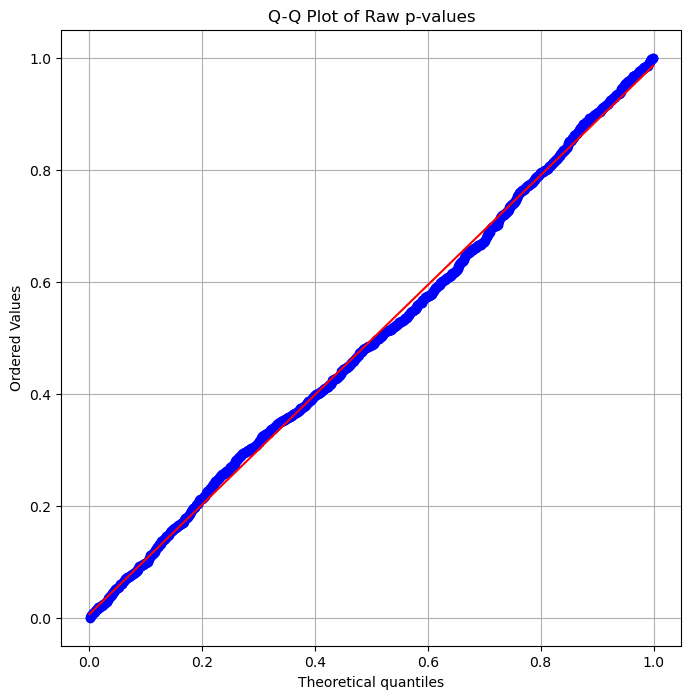

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Example: Assume 'raw_pvals' is a list or array of your raw p-values
# raw_pvals = ...

# Q-Q plot for raw p-values
plt.figure(figsize=(8, 8))
stats.probplot(res.pval, dist="uniform", plot=plt)
plt.title("Q-Q Plot of Raw p-values")
plt.grid(True)
plt.show()


In [13]:
sns.kdeplot(res.bh_fdr)

NameError: name 'sns' is not defined